# Feature_generation-pred_Future2month.ipynb

PBL01_需要予測・在庫最適化　サンプルコード(PBL01_sample_code)   
似ているkaggleのnotebook lag関数やgroupbyを踏まえて, データの整形やり直し

そこで作成したデータセットを使って, モデル作成

## TimeSeriesSplit

https://blog.amedama.jp/entry/time-series-cv

# インポート

In [191]:
import matplotlib.pyplot as plt
# from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
import pandas as pd
import pandas_profiling as pdp
import numpy as np
import os
import lightgbm as lgb

import math
import time

# 複数のリストの直積（デカルト積）を生成するためのライブラリ
from itertools import product


#回帰の可視化
#関数の処理で必要なライブラリ
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import TimeSeriesSplit
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()



from sklearn.ensemble import (
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)

import shap
# import xgboost

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

import warnings
warnings.filterwarnings('ignore')

# pillowをインポート
from PIL import Image
from matplotlib_venn import venn2, venn2_circles

from matplotlib import pyplot
%matplotlib inline

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']

# データの読み込み

In [216]:
data = pd.read_pickle('./inputs/dataset_addfeature_lag_trend_clusters_portfolio.pickle')
# test = pd.read_csv('./inputs/test.csv')
sub = pd.read_csv('./inputs/sample_submission.csv', header=None)
test = pd.read_csv('./inputs/test.csv')
test['商品ID'] = test['商品ID'].astype(str)

In [217]:
data_train = data[(data.月ブロック >= 12) & (data.月ブロック <= 19)]

data_test =  data[data.月ブロック == 21] #10月 → 12月
data_test = data_test[data_test.商品ID.isin(test.商品ID.unique())]
data_test['商品ID'] = data_test['商品ID'].astype(int)
data_test = data_test.sort_values(['商品ID', '店舗ID'])
data_test['商品ID'] = data_test['商品ID'].astype(str)


data = pd.concat([data_train, data_test])

In [218]:
len(data.columns)

490

In [219]:
data.columns[:int(len(data.columns)/5)]

Index(['月ブロック', '店舗ID', '商品ID', '商品価格sum', '商品価格mean', '売上個数', '売上個数mean',
       '購買回数', '売上個数_2month', 'year_cat', 'month_cat', 'year', 'month',
       '月ブロック_cat', 'month_cos', 'month_sin', 'holiday_cnt', '土曜日_cnt',
       '日曜日_cnt', '月曜日_cnt', '木曜日_cnt', '水曜日_cnt', '火曜日_cnt', '金曜日_cnt',
       'item_price_unit', '商品カテゴリID', '商品カテゴリ名', '商品カテゴリ_type1',
       '商品カテゴリ_type2', '商品カテゴリ_type3', 'カテゴリ内_商品数', 'カテゴリtype1内_商品数',
       'カテゴリtype2内_商品数', 'カテゴリtype3内_商品数', '商品カテゴリ名_contains_ゲーム',
       '商品カテゴリ名_contains_PC', '売上個数_lag_1', '売上個数_lag_2', '売上個数_lag_3',
       '売上個数_lag_4', '売上個数_lag_5', '売上個数_lag_6', '売上個数_lag_7', '売上個数_lag_8',
       '売上個数_lag_9', '売上個数_lag_10', '売上個数_lag_11', '売上個数_lag_12',
       '売上個数_date_mean_lag_1', '売上個数_date_mean_lag_2', '売上個数_date_mean_lag_3',
       '売上個数_date_mean_lag_4', '売上個数_date_mean_lag_5', '売上個数_date_mean_lag_6',
       '売上個数_date_mean_lag_7', '売上個数_date_mean_lag_8', '売上個数_date_mean_lag_9',
       '売上個数_date_mean_lag_10', '売上個数_date_mean_lag_11

In [220]:
data = data.drop('商品カテゴリID', axis=1)
data.head()

,月ブロック,店舗ID,商品ID,商品価格sum,商品価格mean,売上個数,売上個数mean,購買回数,売上個数_2month,year_cat,month_cat,year,month,月ブロック_cat,month_cos,month_sin,holiday_cnt,土曜日_cnt,日曜日_cnt,月曜日_cnt,木曜日_cnt,水曜日_cnt,火曜日_cnt,金曜日_cnt,item_price_unit,商品カテゴリ名,商品カテゴリ_type1,商品カテゴリ_type2,商品カテゴリ_type3,カテゴリ内_商品数,カテゴリtype1内_商品数,カテゴリtype2内_商品数,カテゴリtype3内_商品数,商品カテゴリ名_contains_ゲーム,商品カテゴリ名_contains_PC,売上個数_lag_1,売上個数_lag_2,売上個数_lag_3,売上個数_lag_4,売上個数_lag_5,売上個数_lag_6,売上個数_lag_7,売上個数_lag_8,売上個数_lag_9,売上個数_lag_10,売上個数_lag_11,売上個数_lag_12,売上個数_date_mean_lag_1,売上個数_date_mean_lag_2,売上個数_date_mean_lag_3,売上個数_date_mean_lag_4,売上個数_date_mean_lag_5,売上個数_date_mean_lag_6,売上個数_date_mean_lag_7,売上個数_date_mean_lag_8,売上個数_date_mean_lag_9,売上個数_date_mean_lag_10,売上個数_date_mean_lag_11,売上個数_date_mean_lag_12,売上個数_date_std_lag_1,売上個数_date_std_lag_2,売上個数_date_std_lag_3,売上個数_date_std_lag_4,売上個数_date_std_lag_5,売上個数_date_std_lag_6,売上個数_date_std_lag_7,売上個数_date_std_lag_8,売上個数_date_std_lag_9,売上個数_date_std_lag_10,売上個数_date_std_lag_11,売上個数_date_std_lag_12,売上個数_date_max_lag_1,売上個数_date_max_lag_2,売上個数_date_max_lag_3,売上個数_date_max_lag_4,売上個数_date_max_lag_5,売上個数_date_max_lag_6,売上個数_date_max_lag_7,売上個数_date_max_lag_8,売上個数_date_max_lag_9,売上個数_date_max_lag_10,売上個数_date_max_lag_11,売上個数_date_max_lag_12,売上個数_date_min_lag_1,売上個数_date_min_lag_2,売上個数_date_min_lag_3,売上個数_date_min_lag_4,売上個数_date_min_lag_5,売上個数_date_min_lag_6,売上個数_date_min_lag_7,売上個数_date_min_lag_8,売上個数_date_min_lag_9,売上個数_date_min_lag_10,売上個数_date_min_lag_11,売上個数_date_min_lag_12,売上個数_date_itemmean_lag_1,売上個数_date_itemmean_lag_2,売上個数_date_itemmean_lag_3,売上個数_date_itemmean_lag_4,売上個数_date_itemmean_lag_5,売上個数_date_itemmean_lag_6,売上個数_date_itemmean_lag_7,売上個数_date_itemmean_lag_8,売上個数_date_itemmean_lag_9,売上個数_date_itemmean_lag_10,売上個数_date_itemmean_lag_11,売上個数_date_itemmean_lag_12,売上個数_date_itemstd_lag_1,売上個数_date_itemstd_lag_2,売上個数_date_itemstd_lag_3,売上個数_date_itemstd_lag_4,売上個数_date_itemstd_lag_5,売上個数_date_itemstd_lag_6,売上個数_date_itemstd_lag_7,売上個数_date_itemstd_lag_8,売上個数_date_itemstd_lag_9,売上個数_date_itemstd_lag_10,売上個数_date_itemstd_lag_11,売上個数_date_itemstd_lag_12,売上個数_date_itemmax_lag_1,売上個数_date_itemmax_lag_2,売上個数_date_itemmax_lag_3,売上個数_date_itemmax_lag_4,売上個数_date_itemmax_lag_5,売上個数_date_itemmax_lag_6,売上個数_date_itemmax_lag_7,売上個数_date_itemmax_lag_8,売上個数_date_itemmax_lag_9,売上個数_date_itemmax_lag_10,売上個数_date_itemmax_lag_11,売上個数_date_itemmax_lag_12,売上個数_date_itemmin_lag_1,売上個数_date_itemmin_lag_2,売上個数_date_itemmin_lag_3,売上個数_date_itemmin_lag_4,売上個数_date_itemmin_lag_5,売上個数_date_itemmin_lag_6,売上個数_date_itemmin_lag_7,売上個数_date_itemmin_lag_8,売上個数_date_itemmin_lag_9,売上個数_date_itemmin_lag_10,売上個数_date_itemmin_lag_11,売上個数_date_itemmin_lag_12,売上個数_date_shopmean_lag_1,売上個数_date_shopmean_lag_2,売上個数_date_shopmean_lag_3,売上個数_date_shopmean_lag_4,売上個数_date_shopmean_lag_5,売上個数_date_shopmean_lag_6,売上個数_date_shopmean_lag_7,売上個数_date_shopmean_lag_8,売上個数_date_shopmean_lag_9,売上個数_date_shopmean_lag_10,売上個数_date_shopmean_lag_11,売上個数_date_shopmean_lag_12,売上個数_date_shopstd_lag_1,売上個数_date_shopstd_lag_2,売上個数_date_shopstd_lag_3,売上個数_date_shopstd_lag_4,売上個数_date_shopstd_lag_5,売上個数_date_shopstd_lag_6,売上個数_date_shopstd_lag_7,売上個数_date_shopstd_lag_8,売上個数_date_shopstd_lag_9,売上個数_date_shopstd_lag_10,売上個数_date_shopstd_lag_11,売上個数_date_shopstd_lag_12,売上個数_date_shopmax_lag_1,売上個数_date_shopmax_lag_2,売上個数_date_shopmax_lag_3,売上個数_date_shopmax_lag_4,売上個数_date_shopmax_lag_5,売上個数_date_shopmax_lag_6,売上個数_date_shopmax_lag_7,売上個数_date_shopmax_lag_8,売上個数_date_shopmax_lag_9,売上個数_date_shopmax_lag_10,売上個数_date_shopmax_lag_11,売上個数_date_shopmax_lag_12,売上個数_date_shopmin_lag_1,売上個数_date_shopmin_lag_2,売上個数_date_shopmin_lag_3,売上個数_date_shopmin_lag_4,売上個数_date_shopmin_lag_5,売上個数_date_shopmin_lag_6,売上個数_date_shopmin_lag_7,売上個数_date_shopmin_lag_8,売上個数_date_shopmin_lag_9,売上個数_date_shopmin_lag_10,売上個数_date_shopmin_lag_11,売上個数_date_shopmin_lag_12,売上個数_date_catnamemean_lag_1,売上個数_date_catnamemean_lag_2,売上個数_date_catnamemean_lag_3,売上個数_date_catnamemean_lag_4,売上個数_date_catnamemean_lag_5,売上個数_date_catnamemean_lag_6,売上個数_date

## 型

In [221]:
cat_col = [col for col in data.select_dtypes(include=object)]
num_col = [col for col in data.select_dtypes(exclude=object)]

# 関数

In [222]:
#説明変数を対数変換
def logarithmic_transformation(df):
    num_col = [col for col in df.select_dtypes(exclude=object)]
    
    print(num_col)
    #各説明変数の歪度を計算
    skewed_feats = df[num_col].apply(lambda x: x.skew()).sort_values(ascending = False)
    
    #歪度の絶対値が0.5より大きい変数だけに絞る
    skewed_feats_over = skewed_feats[abs(skewed_feats) > 0.5]
    
    #欠損値のないものに絞る
    num_col_feat_list = []
    for i in skewed_feats_over.index:
        flag = df[i].isnull().any()
        if not flag:
            num_col_feat_list.append(i)

    print(num_col_feat_list)
    
    #グラフ化
    skewed_feats_over_plot = skewed_feats_over[num_col_feat_list]
    
    plt.figure(figsize=(20,10))
    plt.xticks(rotation='90')
    sns.barplot(x=skewed_feats_over_plot.index, y=skewed_feats_over_plot)
    
    #Yeo-Johnson変換
    pt = PowerTransformer()
    pt.fit(df[num_col_feat_list])

    #変換後のデータで各列を置換
    tmp = pd.DataFrame()
    tmp[num_col_feat_list] = pt.transform(df[num_col_feat_list])
    tmp = tmp.add_prefix('Log_')
    df[tmp.columns] = tmp
    
    #各説明変数の歪度を計算
    skewed_feats_fixed = df[tmp.columns].apply(lambda x:x.skew()).sort_values(ascending = False)

    #グラフ化
    plt.figure(figsize=(20,10))
    plt.xticks(rotation='90')
    sns.barplot(x=skewed_feats_fixed.index, y=skewed_feats_fixed)

    return df, num_col_feat_list, pt

"""=================================================="""

#カテゴリカル変数化
def process_categorical(df, target_columns):
    df2 = df.copy()
    for column in target_columns:
        df2[column] = LabelEncoder().fit_transform(df2[column].fillna('Na'))

    #ターゲットカラム以外にカテゴリ変数があれば, ダミー変数にする
    #df2 = pd.get_dummies(df2, drop_first=True)
    df2 = pd.get_dummies(df2)

    for column in tqdm(target_columns):
        df2[column] = df2[column].astype('category')

    return df2

"""=================================================="""

#予測値と正解値を描写する関数
def True_Pred_map(pred_df):
    RMSE = np.sqrt(mean_squared_error(pred_df['true'], pred_df['pred']))
    R2 = r2_score(pred_df['true'], pred_df['pred'])
    plt.figure(figsize=(8,8))
    ax = plt.subplot(111)
    ax.scatter('true', 'pred', data=pred_df)
    ax.set_xlabel('True Value', fontsize=15)
    ax.set_ylabel('Pred Value', fontsize=15)
    ax.set_xlim(pred_df.min().min()-0.05 , pred_df.max().max()+0.05)
    ax.set_ylim(pred_df.min().min()-0.05 , pred_df.max().max()+0.05)
    x = np.linspace(pred_df.min().min()-0.05, pred_df.max().max()+0.05, 2)
    y = x
    ax.plot(x,y,'r-')
    plt.text(0.1, 0.9, 'RMSE = {}'.format(str(round(RMSE, 5))), transform=ax.transAxes, fontsize=15)
    plt.text(0.1, 0.8, 'R^2 = {}'.format(str(round(R2, 5))), transform=ax.transAxes, fontsize=15)
    
    
def fit_LabelEncoding(categorical_columns, training_df, test_df):
    
    for column in tqdm(categorical_columns):
        df = test_df.copy()
        le_column = LabelEncoder().fit(training_df[column].fillna('Na'))
        mask = df[column].isin(le_column.classes_)
        column_new_data = df[column].mask(mask).unique()
        le_column.classes_ = np.concatenate([le_column.classes_, column_new_data])
        df[column] = le_column.transform(df[column])

    return df

def fit_dummy(categorical_columns, training_df, test_df):
    df = Today_df.copy()
    fit_dummy_columns = []
    for i in training_df.select_dtypes(include=object).columns.tolist():
        if i not in categorical_columns:
            fit_dummy_columns.append(i)
            
    for column in tqdm(training_df[fit_dummy_columns].columns):
        fit_type = training_df[column].dropna().unique()
        df[column] = pd.Categorical(df[column], fit_type)
        
    df = pd.get_dummies(df, columns=fit_dummy_columns)

    return df

# データセットの整理

In [223]:
X_data = data[(data['月ブロック'] >= 12)].drop(['売上個数_2month'], axis=1)
y_data = data[(data['月ブロック'] >= 12)]['売上個数_2month']

In [224]:
X_data

,月ブロック,店舗ID,商品ID,商品価格sum,商品価格mean,売上個数,売上個数mean,購買回数,year_cat,month_cat,year,month,月ブロック_cat,month_cos,month_sin,holiday_cnt,土曜日_cnt,日曜日_cnt,月曜日_cnt,木曜日_cnt,水曜日_cnt,火曜日_cnt,金曜日_cnt,item_price_unit,商品カテゴリ名,商品カテゴリ_type1,商品カテゴリ_type2,商品カテゴリ_type3,カテゴリ内_商品数,カテゴリtype1内_商品数,カテゴリtype2内_商品数,カテゴリtype3内_商品数,商品カテゴリ名_contains_ゲーム,商品カテゴリ名_contains_PC,売上個数_lag_1,売上個数_lag_2,売上個数_lag_3,売上個数_lag_4,売上個数_lag_5,売上個数_lag_6,売上個数_lag_7,売上個数_lag_8,売上個数_lag_9,売上個数_lag_10,売上個数_lag_11,売上個数_lag_12,売上個数_date_mean_lag_1,売上個数_date_mean_lag_2,売上個数_date_mean_lag_3,売上個数_date_mean_lag_4,売上個数_date_mean_lag_5,売上個数_date_mean_lag_6,売上個数_date_mean_lag_7,売上個数_date_mean_lag_8,売上個数_date_mean_lag_9,売上個数_date_mean_lag_10,売上個数_date_mean_lag_11,売上個数_date_mean_lag_12,売上個数_date_std_lag_1,売上個数_date_std_lag_2,売上個数_date_std_lag_3,売上個数_date_std_lag_4,売上個数_date_std_lag_5,売上個数_date_std_lag_6,売上個数_date_std_lag_7,売上個数_date_std_lag_8,売上個数_date_std_lag_9,売上個数_date_std_lag_10,売上個数_date_std_lag_11,売上個数_date_std_lag_12,売上個数_date_max_lag_1,売上個数_date_max_lag_2,売上個数_date_max_lag_3,売上個数_date_max_lag_4,売上個数_date_max_lag_5,売上個数_date_max_lag_6,売上個数_date_max_lag_7,売上個数_date_max_lag_8,売上個数_date_max_lag_9,売上個数_date_max_lag_10,売上個数_date_max_lag_11,売上個数_date_max_lag_12,売上個数_date_min_lag_1,売上個数_date_min_lag_2,売上個数_date_min_lag_3,売上個数_date_min_lag_4,売上個数_date_min_lag_5,売上個数_date_min_lag_6,売上個数_date_min_lag_7,売上個数_date_min_lag_8,売上個数_date_min_lag_9,売上個数_date_min_lag_10,売上個数_date_min_lag_11,売上個数_date_min_lag_12,売上個数_date_itemmean_lag_1,売上個数_date_itemmean_lag_2,売上個数_date_itemmean_lag_3,売上個数_date_itemmean_lag_4,売上個数_date_itemmean_lag_5,売上個数_date_itemmean_lag_6,売上個数_date_itemmean_lag_7,売上個数_date_itemmean_lag_8,売上個数_date_itemmean_lag_9,売上個数_date_itemmean_lag_10,売上個数_date_itemmean_lag_11,売上個数_date_itemmean_lag_12,売上個数_date_itemstd_lag_1,売上個数_date_itemstd_lag_2,売上個数_date_itemstd_lag_3,売上個数_date_itemstd_lag_4,売上個数_date_itemstd_lag_5,売上個数_date_itemstd_lag_6,売上個数_date_itemstd_lag_7,売上個数_date_itemstd_lag_8,売上個数_date_itemstd_lag_9,売上個数_date_itemstd_lag_10,売上個数_date_itemstd_lag_11,売上個数_date_itemstd_lag_12,売上個数_date_itemmax_lag_1,売上個数_date_itemmax_lag_2,売上個数_date_itemmax_lag_3,売上個数_date_itemmax_lag_4,売上個数_date_itemmax_lag_5,売上個数_date_itemmax_lag_6,売上個数_date_itemmax_lag_7,売上個数_date_itemmax_lag_8,売上個数_date_itemmax_lag_9,売上個数_date_itemmax_lag_10,売上個数_date_itemmax_lag_11,売上個数_date_itemmax_lag_12,売上個数_date_itemmin_lag_1,売上個数_date_itemmin_lag_2,売上個数_date_itemmin_lag_3,売上個数_date_itemmin_lag_4,売上個数_date_itemmin_lag_5,売上個数_date_itemmin_lag_6,売上個数_date_itemmin_lag_7,売上個数_date_itemmin_lag_8,売上個数_date_itemmin_lag_9,売上個数_date_itemmin_lag_10,売上個数_date_itemmin_lag_11,売上個数_date_itemmin_lag_12,売上個数_date_shopmean_lag_1,売上個数_date_shopmean_lag_2,売上個数_date_shopmean_lag_3,売上個数_date_shopmean_lag_4,売上個数_date_shopmean_lag_5,売上個数_date_shopmean_lag_6,売上個数_date_shopmean_lag_7,売上個数_date_shopmean_lag_8,売上個数_date_shopmean_lag_9,売上個数_date_shopmean_lag_10,売上個数_date_shopmean_lag_11,売上個数_date_shopmean_lag_12,売上個数_date_shopstd_lag_1,売上個数_date_shopstd_lag_2,売上個数_date_shopstd_lag_3,売上個数_date_shopstd_lag_4,売上個数_date_shopstd_lag_5,売上個数_date_shopstd_lag_6,売上個数_date_shopstd_lag_7,売上個数_date_shopstd_lag_8,売上個数_date_shopstd_lag_9,売上個数_date_shopstd_lag_10,売上個数_date_shopstd_lag_11,売上個数_date_shopstd_lag_12,売上個数_date_shopmax_lag_1,売上個数_date_shopmax_lag_2,売上個数_date_shopmax_lag_3,売上個数_date_shopmax_lag_4,売上個数_date_shopmax_lag_5,売上個数_date_shopmax_lag_6,売上個数_date_shopmax_lag_7,売上個数_date_shopmax_lag_8,売上個数_date_shopmax_lag_9,売上個数_date_shopmax_lag_10,売上個数_date_shopmax_lag_11,売上個数_date_shopmax_lag_12,売上個数_date_shopmin_lag_1,売上個数_date_shopmin_lag_2,売上個数_date_shopmin_lag_3,売上個数_date_shopmin_lag_4,売上個数_date_shopmin_lag_5,売上個数_date_shopmin_lag_6,売上個数_date_shopmin_lag_7,売上個数_date_shopmin_lag_8,売上個数_date_shopmin_lag_9,売上個数_date_shopmin_lag_10,売上個数_date_shopmin_lag_11,売上個数_date_shopmin_lag_12,売上個数_date_catnamemean_lag_1,売上個数_date_catnamemean_lag_2,売上個数_date_catnamemean_lag_3,売上個数_date_catnamemean_lag_4,売上個数_date_catnamemean_lag_5,売上個数_date_catnamemean_lag_6,売上個数_date_catnamemean

In [225]:
y_data

988722     0.0
988723     1.0
988724     0.0
988725     2.0
988726     3.0
          ... 
1635630    NaN
1638844    NaN
1642058    NaN
1645272    NaN
1648486    NaN
Name: 売上個数_2month, Length: 547956, dtype: float16

## カテゴリ変数化

In [226]:
cat_col

['店舗ID',
 '商品ID',
 'year_cat',
 'month_cat',
 '月ブロック_cat',
 '商品カテゴリ名',
 '商品カテゴリ_type1',
 '商品カテゴリ_type2',
 '商品カテゴリ_type3',
 '店舗別_売上個数_クラスタ_cat',
 '商品別_売上個数_クラスタ_cat']

In [227]:
for cat in cat_col:
    print(cat)
    print(X_data[cat].nunique(dropna=False))
    print('*' * 100)

店舗ID
18
****************************************************************************************************
商品ID
6288
****************************************************************************************************
year_cat
1
****************************************************************************************************
month_cat
9
****************************************************************************************************
月ブロック_cat
9
****************************************************************************************************
商品カテゴリ名
26
****************************************************************************************************
商品カテゴリ_type1
8
****************************************************************************************************
商品カテゴリ_type2
22
****************************************************************************************************
商品カテゴリ_type3
3
**********************************************************************************

In [228]:
#labelencodingするカラム → コメントアウト one-hot変換
labelencoding_columns = [
    #'店舗ID',
 '商品ID',
 #'year_cat',
 #'month_cat',
 #'月ブロック_cat',
 '商品カテゴリ名',
 #'商品カテゴリ_type1',
 #'商品カテゴリ_type2',
 #'商品カテゴリ_type3',
#'店舗別_売上個数_クラスタ_cat',
 #'商品別_売上個数_クラスタ_cat'
]

X_data_dummy = process_categorical(X_data, labelencoding_columns)

  0%|          | 0/2 [00:00<?, ?it/s]

# データセットを入力値、目標値に分割

In [229]:
X_data_dummy.月ブロック.unique()

array([12, 13, 14, 15, 16, 17, 18, 19, 21])

In [231]:
# 学習データとしては、「12ヶ月前の売上個数」カラムが存在するレコードのみを抽出する
X_trainval = X_data_dummy[(X_data_dummy.月ブロック >= 12) & (X_data_dummy.月ブロック <= 19)]
y_trainval = y_data[(X_data_dummy.月ブロック>= 12) & (X_data_dummy.月ブロック <= 19)] #1 ~ 8月 → 3月 ~ 10月

X_test = X_data_dummy[X_data_dummy.月ブロック == 21] #10月 → 12月

In [233]:
X_trainval

,月ブロック,商品ID,商品価格sum,商品価格mean,売上個数,売上個数mean,購買回数,year,month,month_cos,month_sin,holiday_cnt,土曜日_cnt,日曜日_cnt,月曜日_cnt,木曜日_cnt,水曜日_cnt,火曜日_cnt,金曜日_cnt,item_price_unit,商品カテゴリ名,カテゴリ内_商品数,カテゴリtype1内_商品数,カテゴリtype2内_商品数,カテゴリtype3内_商品数,商品カテゴリ名_contains_ゲーム,商品カテゴリ名_contains_PC,売上個数_lag_1,売上個数_lag_2,売上個数_lag_3,売上個数_lag_4,売上個数_lag_5,売上個数_lag_6,売上個数_lag_7,売上個数_lag_8,売上個数_lag_9,売上個数_lag_10,売上個数_lag_11,売上個数_lag_12,売上個数_date_mean_lag_1,売上個数_date_mean_lag_2,売上個数_date_mean_lag_3,売上個数_date_mean_lag_4,売上個数_date_mean_lag_5,売上個数_date_mean_lag_6,売上個数_date_mean_lag_7,売上個数_date_mean_lag_8,売上個数_date_mean_lag_9,売上個数_date_mean_lag_10,売上個数_date_mean_lag_11,売上個数_date_mean_lag_12,売上個数_date_std_lag_1,売上個数_date_std_lag_2,売上個数_date_std_lag_3,売上個数_date_std_lag_4,売上個数_date_std_lag_5,売上個数_date_std_lag_6,売上個数_date_std_lag_7,売上個数_date_std_lag_8,売上個数_date_std_lag_9,売上個数_date_std_lag_10,売上個数_date_std_lag_11,売上個数_date_std_lag_12,売上個数_date_max_lag_1,売上個数_date_max_lag_2,売上個数_date_max_lag_3,売上個数_date_max_lag_4,売上個数_date_max_lag_5,売上個数_date_max_lag_6,売上個数_date_max_lag_7,売上個数_date_max_lag_8,売上個数_date_max_lag_9,売上個数_date_max_lag_10,売上個数_date_max_lag_11,売上個数_date_max_lag_12,売上個数_date_min_lag_1,売上個数_date_min_lag_2,売上個数_date_min_lag_3,売上個数_date_min_lag_4,売上個数_date_min_lag_5,売上個数_date_min_lag_6,売上個数_date_min_lag_7,売上個数_date_min_lag_8,売上個数_date_min_lag_9,売上個数_date_min_lag_10,売上個数_date_min_lag_11,売上個数_date_min_lag_12,売上個数_date_itemmean_lag_1,売上個数_date_itemmean_lag_2,売上個数_date_itemmean_lag_3,売上個数_date_itemmean_lag_4,売上個数_date_itemmean_lag_5,売上個数_date_itemmean_lag_6,売上個数_date_itemmean_lag_7,売上個数_date_itemmean_lag_8,売上個数_date_itemmean_lag_9,売上個数_date_itemmean_lag_10,売上個数_date_itemmean_lag_11,売上個数_date_itemmean_lag_12,売上個数_date_itemstd_lag_1,売上個数_date_itemstd_lag_2,売上個数_date_itemstd_lag_3,売上個数_date_itemstd_lag_4,売上個数_date_itemstd_lag_5,売上個数_date_itemstd_lag_6,売上個数_date_itemstd_lag_7,売上個数_date_itemstd_lag_8,売上個数_date_itemstd_lag_9,売上個数_date_itemstd_lag_10,売上個数_date_itemstd_lag_11,売上個数_date_itemstd_lag_12,売上個数_date_itemmax_lag_1,売上個数_date_itemmax_lag_2,売上個数_date_itemmax_lag_3,売上個数_date_itemmax_lag_4,売上個数_date_itemmax_lag_5,売上個数_date_itemmax_lag_6,売上個数_date_itemmax_lag_7,売上個数_date_itemmax_lag_8,売上個数_date_itemmax_lag_9,売上個数_date_itemmax_lag_10,売上個数_date_itemmax_lag_11,売上個数_date_itemmax_lag_12,売上個数_date_itemmin_lag_1,売上個数_date_itemmin_lag_2,売上個数_date_itemmin_lag_3,売上個数_date_itemmin_lag_4,売上個数_date_itemmin_lag_5,売上個数_date_itemmin_lag_6,売上個数_date_itemmin_lag_7,売上個数_date_itemmin_lag_8,売上個数_date_itemmin_lag_9,売上個数_date_itemmin_lag_10,売上個数_date_itemmin_lag_11,売上個数_date_itemmin_lag_12,売上個数_date_shopmean_lag_1,売上個数_date_shopmean_lag_2,売上個数_date_shopmean_lag_3,売上個数_date_shopmean_lag_4,売上個数_date_shopmean_lag_5,売上個数_date_shopmean_lag_6,売上個数_date_shopmean_lag_7,売上個数_date_shopmean_lag_8,売上個数_date_shopmean_lag_9,売上個数_date_shopmean_lag_10,売上個数_date_shopmean_lag_11,売上個数_date_shopmean_lag_12,売上個数_date_shopstd_lag_1,売上個数_date_shopstd_lag_2,売上個数_date_shopstd_lag_3,売上個数_date_shopstd_lag_4,売上個数_date_shopstd_lag_5,売上個数_date_shopstd_lag_6,売上個数_date_shopstd_lag_7,売上個数_date_shopstd_lag_8,売上個数_date_shopstd_lag_9,売上個数_date_shopstd_lag_10,売上個数_date_shopstd_lag_11,売上個数_date_shopstd_lag_12,売上個数_date_shopmax_lag_1,売上個数_date_shopmax_lag_2,売上個数_date_shopmax_lag_3,売上個数_date_shopmax_lag_4,売上個数_date_shopmax_lag_5,売上個数_date_shopmax_lag_6,売上個数_date_shopmax_lag_7,売上個数_date_shopmax_lag_8,売上個数_date_shopmax_lag_9,売上個数_date_shopmax_lag_10,売上個数_date_shopmax_lag_11,売上個数_date_shopmax_lag_12,売上個数_date_shopmin_lag_1,売上個数_date_shopmin_lag_2,売上個数_date_shopmin_lag_3,売上個数_date_shopmin_lag_4,売上個数_date_shopmin_lag_5,売上個数_date_shopmin_lag_6,売上個数_date_shopmin_lag_7,売上個数_date_shopmin_lag_8,売上個数_date_shopmin_lag_9,売上個数_date_shopmin_lag_10,売上個数_date_shopmin_lag_11,売上個数_date_shopmin_lag_12,売上個数_date_catnamemean_lag_1,売上個数_date_catnamemean_lag_2,売上個数_date_catnamemean_lag_3,売上個数_date_catnamemean_lag_4,売上個数_date_catnamemean_lag_5,売上個数_date_catnamemean_lag_6,売上個数_date_catnamemean_lag_7,売上個数_date_catnamemean_lag_8,売上個数_date_catnamemean_lag_9,売上個数_date_

In [234]:
y_trainval

988722     0.0
988723     1.0
988724     0.0
988725     2.0
988726     3.0
          ... 
1533613    0.0
1533614    0.0
1533615    0.0
1533616    0.0
1533617    0.0
Name: 売上個数_2month, Length: 544896, dtype: float16

In [235]:
y_trainval[y_trainval.isnull()]

Series([], Name: 売上個数_2month, dtype: float16)

# 目的変数の前処理

y_train
歪度: nan
尖度: nan
np.exp(train_y_log)
歪度: nan
尖度: nan
2回 np.exp(train_y_log)
歪度: nan
尖度: nan


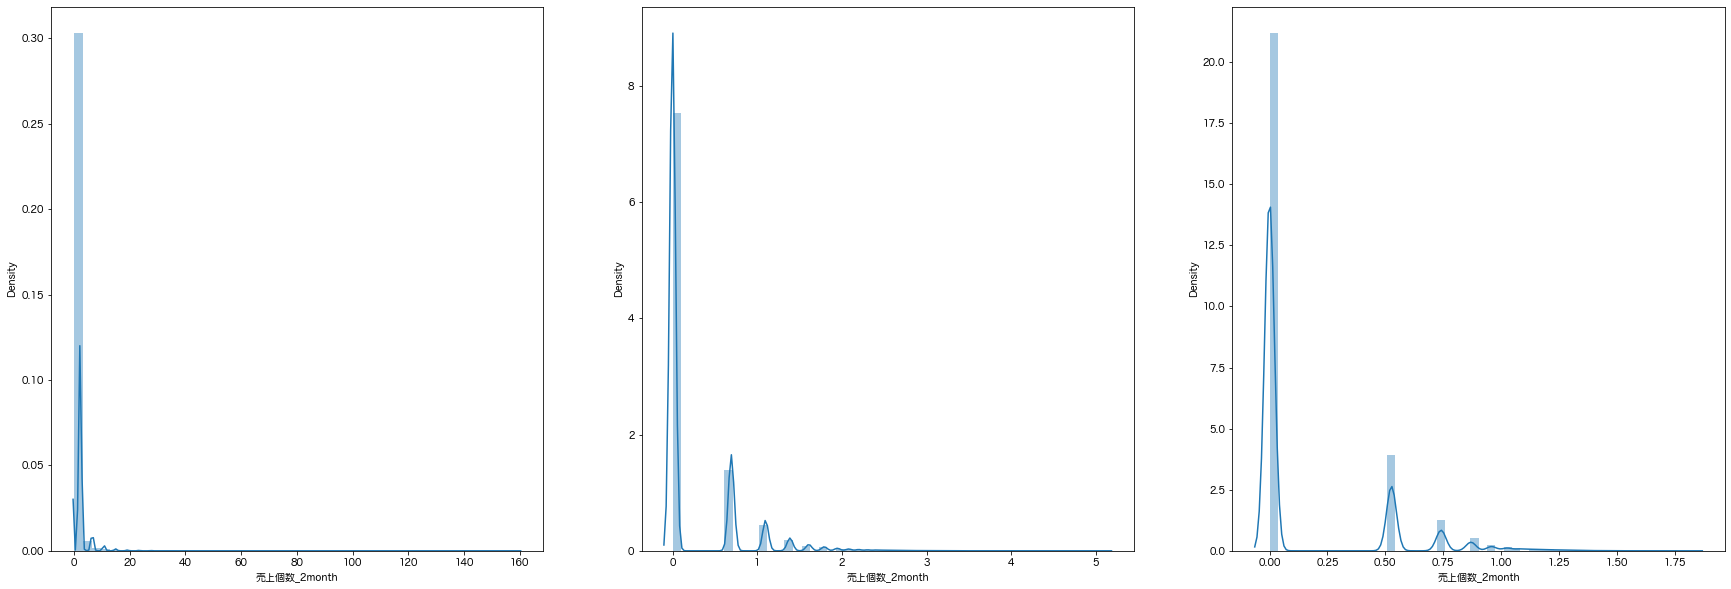

In [237]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[30, 10])

sns.distplot(y_data[y_data.notnull()], ax=ax1)
#歪度と尖度を計算
print('y_train')
print("歪度: %f" % y_data.skew())
print("尖度: %f" % y_data.kurt())

print('=============')
y_data_log1p = np.log1p(y_data[y_data.notnull()])
sns.distplot(y_data_log1p, ax=ax2)
print('np.exp(train_y_log)')
#歪度と尖度を計算
print("歪度: %f" % y_data_log1p.skew())
print("尖度: %f" % y_data_log1p.kurt())

print('=============')
y_data_log1p_log1p = np.log1p(y_data_log1p)
sns.distplot(y_data_log1p_log1p, ax=ax3)
print('2回 np.exp(train_y_log)')
#歪度と尖度を計算
print("歪度: %f" % y_data_log1p_log1p.skew())
print("尖度: %f" % y_data_log1p_log1p.kurt())

# パラメータチューニング¶

In [238]:
X_trainval

,月ブロック,商品ID,商品価格sum,商品価格mean,売上個数,売上個数mean,購買回数,year,month,month_cos,month_sin,holiday_cnt,土曜日_cnt,日曜日_cnt,月曜日_cnt,木曜日_cnt,水曜日_cnt,火曜日_cnt,金曜日_cnt,item_price_unit,商品カテゴリ名,カテゴリ内_商品数,カテゴリtype1内_商品数,カテゴリtype2内_商品数,カテゴリtype3内_商品数,商品カテゴリ名_contains_ゲーム,商品カテゴリ名_contains_PC,売上個数_lag_1,売上個数_lag_2,売上個数_lag_3,売上個数_lag_4,売上個数_lag_5,売上個数_lag_6,売上個数_lag_7,売上個数_lag_8,売上個数_lag_9,売上個数_lag_10,売上個数_lag_11,売上個数_lag_12,売上個数_date_mean_lag_1,売上個数_date_mean_lag_2,売上個数_date_mean_lag_3,売上個数_date_mean_lag_4,売上個数_date_mean_lag_5,売上個数_date_mean_lag_6,売上個数_date_mean_lag_7,売上個数_date_mean_lag_8,売上個数_date_mean_lag_9,売上個数_date_mean_lag_10,売上個数_date_mean_lag_11,売上個数_date_mean_lag_12,売上個数_date_std_lag_1,売上個数_date_std_lag_2,売上個数_date_std_lag_3,売上個数_date_std_lag_4,売上個数_date_std_lag_5,売上個数_date_std_lag_6,売上個数_date_std_lag_7,売上個数_date_std_lag_8,売上個数_date_std_lag_9,売上個数_date_std_lag_10,売上個数_date_std_lag_11,売上個数_date_std_lag_12,売上個数_date_max_lag_1,売上個数_date_max_lag_2,売上個数_date_max_lag_3,売上個数_date_max_lag_4,売上個数_date_max_lag_5,売上個数_date_max_lag_6,売上個数_date_max_lag_7,売上個数_date_max_lag_8,売上個数_date_max_lag_9,売上個数_date_max_lag_10,売上個数_date_max_lag_11,売上個数_date_max_lag_12,売上個数_date_min_lag_1,売上個数_date_min_lag_2,売上個数_date_min_lag_3,売上個数_date_min_lag_4,売上個数_date_min_lag_5,売上個数_date_min_lag_6,売上個数_date_min_lag_7,売上個数_date_min_lag_8,売上個数_date_min_lag_9,売上個数_date_min_lag_10,売上個数_date_min_lag_11,売上個数_date_min_lag_12,売上個数_date_itemmean_lag_1,売上個数_date_itemmean_lag_2,売上個数_date_itemmean_lag_3,売上個数_date_itemmean_lag_4,売上個数_date_itemmean_lag_5,売上個数_date_itemmean_lag_6,売上個数_date_itemmean_lag_7,売上個数_date_itemmean_lag_8,売上個数_date_itemmean_lag_9,売上個数_date_itemmean_lag_10,売上個数_date_itemmean_lag_11,売上個数_date_itemmean_lag_12,売上個数_date_itemstd_lag_1,売上個数_date_itemstd_lag_2,売上個数_date_itemstd_lag_3,売上個数_date_itemstd_lag_4,売上個数_date_itemstd_lag_5,売上個数_date_itemstd_lag_6,売上個数_date_itemstd_lag_7,売上個数_date_itemstd_lag_8,売上個数_date_itemstd_lag_9,売上個数_date_itemstd_lag_10,売上個数_date_itemstd_lag_11,売上個数_date_itemstd_lag_12,売上個数_date_itemmax_lag_1,売上個数_date_itemmax_lag_2,売上個数_date_itemmax_lag_3,売上個数_date_itemmax_lag_4,売上個数_date_itemmax_lag_5,売上個数_date_itemmax_lag_6,売上個数_date_itemmax_lag_7,売上個数_date_itemmax_lag_8,売上個数_date_itemmax_lag_9,売上個数_date_itemmax_lag_10,売上個数_date_itemmax_lag_11,売上個数_date_itemmax_lag_12,売上個数_date_itemmin_lag_1,売上個数_date_itemmin_lag_2,売上個数_date_itemmin_lag_3,売上個数_date_itemmin_lag_4,売上個数_date_itemmin_lag_5,売上個数_date_itemmin_lag_6,売上個数_date_itemmin_lag_7,売上個数_date_itemmin_lag_8,売上個数_date_itemmin_lag_9,売上個数_date_itemmin_lag_10,売上個数_date_itemmin_lag_11,売上個数_date_itemmin_lag_12,売上個数_date_shopmean_lag_1,売上個数_date_shopmean_lag_2,売上個数_date_shopmean_lag_3,売上個数_date_shopmean_lag_4,売上個数_date_shopmean_lag_5,売上個数_date_shopmean_lag_6,売上個数_date_shopmean_lag_7,売上個数_date_shopmean_lag_8,売上個数_date_shopmean_lag_9,売上個数_date_shopmean_lag_10,売上個数_date_shopmean_lag_11,売上個数_date_shopmean_lag_12,売上個数_date_shopstd_lag_1,売上個数_date_shopstd_lag_2,売上個数_date_shopstd_lag_3,売上個数_date_shopstd_lag_4,売上個数_date_shopstd_lag_5,売上個数_date_shopstd_lag_6,売上個数_date_shopstd_lag_7,売上個数_date_shopstd_lag_8,売上個数_date_shopstd_lag_9,売上個数_date_shopstd_lag_10,売上個数_date_shopstd_lag_11,売上個数_date_shopstd_lag_12,売上個数_date_shopmax_lag_1,売上個数_date_shopmax_lag_2,売上個数_date_shopmax_lag_3,売上個数_date_shopmax_lag_4,売上個数_date_shopmax_lag_5,売上個数_date_shopmax_lag_6,売上個数_date_shopmax_lag_7,売上個数_date_shopmax_lag_8,売上個数_date_shopmax_lag_9,売上個数_date_shopmax_lag_10,売上個数_date_shopmax_lag_11,売上個数_date_shopmax_lag_12,売上個数_date_shopmin_lag_1,売上個数_date_shopmin_lag_2,売上個数_date_shopmin_lag_3,売上個数_date_shopmin_lag_4,売上個数_date_shopmin_lag_5,売上個数_date_shopmin_lag_6,売上個数_date_shopmin_lag_7,売上個数_date_shopmin_lag_8,売上個数_date_shopmin_lag_9,売上個数_date_shopmin_lag_10,売上個数_date_shopmin_lag_11,売上個数_date_shopmin_lag_12,売上個数_date_catnamemean_lag_1,売上個数_date_catnamemean_lag_2,売上個数_date_catnamemean_lag_3,売上個数_date_catnamemean_lag_4,売上個数_date_catnamemean_lag_5,売上個数_date_catnamemean_lag_6,売上個数_date_catnamemean_lag_7,売上個数_date_catnamemean_lag_8,売上個数_date_catnamemean_lag_9,売上個数_date_

In [239]:
y_trainval

988722     0.0
988723     1.0
988724     0.0
988725     2.0
988726     3.0
          ... 
1533613    0.0
1533614    0.0
1533615    0.0
1533616    0.0
1533617    0.0
Name: 売上個数_2month, Length: 544896, dtype: float16

In [240]:
# 学習データとしては、「12ヶ月前の売上個数」カラムが存在するレコードのみを抽出する
X_train = X_trainval[(X_trainval.月ブロック >= 12) & (X_trainval.月ブロック <= 18)]
y_train = y_trainval[(X_trainval.月ブロック>= 12) & (X_trainval.月ブロック<= 18)]

X_valid = X_trainval[X_trainval.月ブロック == 19] #10月 → 12月
y_valid = y_trainval[X_trainval.月ブロック == 19]

In [241]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(483030, 563)
(483030,)
(61866, 563)
(61866,)


In [242]:
import optuna.integration.lightgbm as op_lgb
from sklearn import datasets, model_selection

dtrain_tuning = op_lgb.Dataset(X_train.values, label=y_train.values)
dval_tuning = op_lgb.Dataset(X_valid.values, label=y_valid.values)

In [243]:
ts = time.time()

best_params, tuning_history = dict(), list()
# ハイパーパラメータサーチ&モデル構築(回帰モデル用)
tuning_params = {'objective': 'regression',
          'metric': 'rmse',
          'num_boost_round': 5000, # 最大試行数
          'random_seed':100,
         'learning_rate': 0.01, # 学習率
         }

booster = op_lgb.train(tuning_params, 
                       dtrain_tuning, 
                       valid_sets=[dtrain_tuning, dval_tuning],
                       verbose_eval=1000,
                       early_stopping_rounds=3,)

time.time() - ts

[I 2021-10-05 23:11:14,658] A new study created in memory with name: no-name-edf27eda-620b-4f37-a6e2-a1597d416ef5
feature_fraction, val_score: inf:   0%|                   | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.164447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


feature_fraction, val_score: 1.368026:  14%|8     | 1/7 [00:31<03:06, 31.16s/it]

Early stopping, best iteration is:
[400]	valid_0's rmse: 0.953021	valid_1's rmse: 1.36803
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.121883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


feature_fraction, val_score: 1.368026:  29%|#7    | 2/7 [01:14<03:11, 38.27s/it]

Early stopping, best iteration is:
[372]	valid_0's rmse: 0.964173	valid_1's rmse: 1.36895
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.160354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


feature_fraction, val_score: 1.368026:  43%|##5   | 3/7 [01:42<02:14, 33.57s/it]

Early stopping, best iteration is:
[390]	valid_0's rmse: 0.956513	valid_1's rmse: 1.36904
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.145598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


feature_fraction, val_score: 1.367069:  57%|###4  | 4/7 [02:13<01:37, 32.53s/it]

Early stopping, best iteration is:
[465]	valid_0's rmse: 0.941998	valid_1's rmse: 1.36707
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.108022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


feature_fraction, val_score: 1.367069:  71%|####2 | 5/7 [02:57<01:13, 36.74s/it]

Early stopping, best iteration is:
[412]	valid_0's rmse: 0.956415	valid_1's rmse: 1.36751
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.139748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


feature_fraction, val_score: 1.367069:  86%|#####1| 6/7 [03:25<00:33, 33.92s/it]

Early stopping, best iteration is:
[404]	valid_0's rmse: 0.953832	valid_1's rmse: 1.36811
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.177371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


feature_fraction, val_score: 1.361648: 100%|######| 7/7 [03:59<00:00, 34.21s/it]


Early stopping, best iteration is:
[495]	valid_0's rmse: 0.933168	valid_1's rmse: 1.36165


num_leaves, val_score: 1.361648:   0%|                   | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.160259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


num_leaves, val_score: 1.361648:   5%|5          | 1/20 [00:29<09:23, 29.64s/it]

Early stopping, best iteration is:
[396]	valid_0's rmse: 0.961991	valid_1's rmse: 1.37087
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.174828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


num_leaves, val_score: 1.361491:  10%|#1         | 2/20 [01:20<12:39, 42.19s/it]

Early stopping, best iteration is:
[346]	valid_0's rmse: 0.8394	valid_1's rmse: 1.36149
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.162644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


num_leaves, val_score: 1.357700:  15%|#6         | 3/20 [02:22<14:30, 51.22s/it]

Early stopping, best iteration is:
[389]	valid_0's rmse: 0.799686	valid_1's rmse: 1.3577
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.176400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


num_leaves, val_score: 1.357700:  20%|##2        | 4/20 [03:29<15:21, 57.61s/it]

Early stopping, best iteration is:
[395]	valid_0's rmse: 0.791086	valid_1's rmse: 1.35781
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.176773 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


num_leaves, val_score: 1.357700:  25%|##7        | 5/20 [04:20<13:46, 55.12s/it]

Early stopping, best iteration is:
[323]	valid_0's rmse: 0.835745	valid_1's rmse: 1.36135
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.183718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


num_leaves, val_score: 1.356104:  30%|###3       | 6/20 [05:27<13:48, 59.16s/it]

Early stopping, best iteration is:
[435]	valid_0's rmse: 0.791885	valid_1's rmse: 1.3561
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.171430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


num_leaves, val_score: 1.356104:  35%|###8       | 7/20 [06:16<12:04, 55.73s/it]

Early stopping, best iteration is:
[349]	valid_0's rmse: 0.838312	valid_1's rmse: 1.36109
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.162131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


num_leaves, val_score: 1.356104:  40%|####4      | 8/20 [06:50<09:47, 48.97s/it]

Early stopping, best iteration is:
[372]	valid_0's rmse: 0.915721	valid_1's rmse: 1.36055
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.169891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


num_leaves, val_score: 1.356104:  45%|####9      | 9/20 [07:35<08:42, 47.53s/it]

Early stopping, best iteration is:
[389]	valid_0's rmse: 0.860712	valid_1's rmse: 1.35654
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.183337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


num_leaves, val_score: 1.356104:  50%|#####     | 10/20 [08:24<08:01, 48.12s/it]

Early stopping, best iteration is:
[292]	valid_0's rmse: 0.836865	valid_1's rmse: 1.36331
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.173752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


num_leaves, val_score: 1.356104:  55%|#####5    | 11/20 [09:09<07:03, 47.10s/it]

Early stopping, best iteration is:
[373]	valid_0's rmse: 0.859665	valid_1's rmse: 1.35913
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.173947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


num_leaves, val_score: 1.356104:  60%|######    | 12/20 [09:51<06:05, 45.65s/it]

Early stopping, best iteration is:
[374]	valid_0's rmse: 0.871582	valid_1's rmse: 1.35838
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.179613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


num_leaves, val_score: 1.356104:  65%|######5   | 13/20 [10:33<05:10, 44.34s/it]

Early stopping, best iteration is:
[388]	valid_0's rmse: 0.879314	valid_1's rmse: 1.35621
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.188978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


num_leaves, val_score: 1.356104:  70%|#######   | 14/20 [11:10<04:13, 42.28s/it]

Early stopping, best iteration is:
[380]	valid_0's rmse: 0.903725	valid_1's rmse: 1.3597
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.191225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


num_leaves, val_score: 1.356104:  75%|#######5  | 15/20 [12:01<03:44, 44.81s/it]

Early stopping, best iteration is:
[361]	valid_0's rmse: 0.840034	valid_1's rmse: 1.35861
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.198703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


num_leaves, val_score: 1.356104:  80%|########  | 16/20 [12:44<02:57, 44.27s/it]

Early stopping, best iteration is:
[435]	valid_0's rmse: 0.894228	valid_1's rmse: 1.35669
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.197551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


num_leaves, val_score: 1.356104:  85%|########5 | 17/20 [13:44<02:27, 49.13s/it]

Early stopping, best iteration is:
[449]	valid_0's rmse: 0.820166	valid_1's rmse: 1.35668
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.206279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


num_leaves, val_score: 1.356104:  90%|######### | 18/20 [14:29<01:35, 47.82s/it]

Early stopping, best iteration is:
[388]	valid_0's rmse: 0.879314	valid_1's rmse: 1.35621
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.195534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds
[1000]	valid_0's rmse: 1.14672	valid_1's rmse: 1.42398


num_leaves, val_score: 1.356104:  95%|#########5| 19/20 [15:12<00:46, 46.38s/it]

Early stopping, best iteration is:
[1148]	valid_0's rmse: 1.14167	valid_1's rmse: 1.4214
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.185394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


num_leaves, val_score: 1.356104: 100%|##########| 20/20 [16:12<00:00, 48.61s/it]


Early stopping, best iteration is:
[382]	valid_0's rmse: 0.810388	valid_1's rmse: 1.35703


bagging, val_score: 1.356104:   0%|                      | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.185761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


bagging, val_score: 1.356104:  10%|#4            | 1/10 [00:50<07:34, 50.53s/it]

Early stopping, best iteration is:
[356]	valid_0's rmse: 0.833718	valid_1's rmse: 1.36016
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.187131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


bagging, val_score: 1.356104:  20%|##8           | 2/10 [01:59<08:11, 61.38s/it]

Early stopping, best iteration is:
[385]	valid_0's rmse: 0.808249	valid_1's rmse: 1.35775
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.177555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


bagging, val_score: 1.356104:  30%|####2         | 3/10 [02:53<06:44, 57.84s/it]

Early stopping, best iteration is:
[332]	valid_0's rmse: 0.839237	valid_1's rmse: 1.36131
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.198624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


bagging, val_score: 1.356104:  40%|#####6        | 4/10 [03:50<05:45, 57.63s/it]

Early stopping, best iteration is:
[342]	valid_0's rmse: 0.832493	valid_1's rmse: 1.35892
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.205987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


bagging, val_score: 1.355023:  50%|#######       | 5/10 [04:40<04:34, 54.83s/it]

Early stopping, best iteration is:
[349]	valid_0's rmse: 0.853068	valid_1's rmse: 1.35502
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.194749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


bagging, val_score: 1.355023:  60%|########4     | 6/10 [05:27<03:28, 52.15s/it]

Early stopping, best iteration is:
[298]	valid_0's rmse: 0.860442	valid_1's rmse: 1.36047
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.214608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


bagging, val_score: 1.355023:  70%|#########7    | 7/10 [06:12<02:29, 49.99s/it]

Early stopping, best iteration is:
[318]	valid_0's rmse: 0.867228	valid_1's rmse: 1.36029
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.195704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


bagging, val_score: 1.355023:  80%|###########2  | 8/10 [07:00<01:38, 49.31s/it]

Early stopping, best iteration is:
[278]	valid_0's rmse: 0.862603	valid_1's rmse: 1.36257
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.177975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


bagging, val_score: 1.355023:  90%|############6 | 9/10 [07:55<00:51, 51.07s/it]

Early stopping, best iteration is:
[333]	valid_0's rmse: 0.842319	valid_1's rmse: 1.36057
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.189567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


bagging, val_score: 1.355023: 100%|#############| 10/10 [08:38<00:00, 51.90s/it]


Early stopping, best iteration is:
[279]	valid_0's rmse: 0.864607	valid_1's rmse: 1.36565


feature_fraction_stage2, val_score: 1.355023:   0%|       | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.180898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


feature_fraction_stage2, val_score: 1.355023:  17%|1| 1/6 [00:44<03:44, 44.84s/i[I 2021-10-05 23:40:50,129] Trial 37 finished with value: 1.3563760692614197 and parameters: {'feature_fraction': 0.8839999999999999}. Best is trial 37 with value: 1.3563760692614197.
feature_fraction_stage2, val_score: 1.355023:  17%|1| 1/6 [00:44<03:44, 44.84s/i

Early stopping, best iteration is:
[355]	valid_0's rmse: 0.850933	valid_1's rmse: 1.35638
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.199224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


feature_fraction_stage2, val_score: 1.355023:  33%|3| 2/6 [01:24<02:47, 41.91s/i[I 2021-10-05 23:41:29,988] Trial 38 finished with value: 1.3611727335640835 and parameters: {'feature_fraction': 0.9799999999999999}. Best is trial 37 with value: 1.3563760692614197.
feature_fraction_stage2, val_score: 1.355023:  33%|3| 2/6 [01:24<02:47, 41.91s/i

Early stopping, best iteration is:
[300]	valid_0's rmse: 0.87377	valid_1's rmse: 1.36117
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.179375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


feature_fraction_stage2, val_score: 1.355023:  50%|5| 3/6 [02:04<02:02, 40.89s/i[I 2021-10-05 23:42:09,671] Trial 39 finished with value: 1.3595420803246787 and parameters: {'feature_fraction': 0.9159999999999999}. Best is trial 37 with value: 1.3563760692614197.
feature_fraction_stage2, val_score: 1.355023:  50%|5| 3/6 [02:04<02:02, 40.89s/i

Early stopping, best iteration is:
[300]	valid_0's rmse: 0.873658	valid_1's rmse: 1.35954
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.183302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


feature_fraction_stage2, val_score: 1.355023:  67%|6| 4/6 [02:48<01:24, 42.32s/i[I 2021-10-05 23:42:54,187] Trial 40 finished with value: 1.355863314451703 and parameters: {'feature_fraction': 0.852}. Best is trial 40 with value: 1.355863314451703.
feature_fraction_stage2, val_score: 1.355023:  67%|6| 4/6 [02:48<01:24, 42.32s/i

Early stopping, best iteration is:
[355]	valid_0's rmse: 0.851402	valid_1's rmse: 1.35586
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.182654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


feature_fraction_stage2, val_score: 1.355023:  83%|8| 5/6 [03:30<00:42, 42.23s/i[I 2021-10-05 23:43:36,244] Trial 41 finished with value: 1.3578098548058628 and parameters: {'feature_fraction': 0.948}. Best is trial 40 with value: 1.355863314451703.
feature_fraction_stage2, val_score: 1.355023:  83%|8| 5/6 [03:30<00:42, 42.23s/i

Early stopping, best iteration is:
[325]	valid_0's rmse: 0.862479	valid_1's rmse: 1.35781
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.187080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


feature_fraction_stage2, val_score: 1.355023: 100%|#| 6/6 [04:12<00:00, 41.90s/i[I 2021-10-05 23:44:17,523] Trial 42 finished with value: 1.3598329085820675 and parameters: {'feature_fraction': 0.82}. Best is trial 40 with value: 1.355863314451703.
feature_fraction_stage2, val_score: 1.355023: 100%|#| 6/6 [04:12<00:00, 42.04s/i


Early stopping, best iteration is:
[311]	valid_0's rmse: 0.869527	valid_1's rmse: 1.35983


regularization_factors, val_score: 1.355023:   0%|       | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.179517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


regularization_factors, val_score: 1.354455:   5%| | 1/20 [00:48<15:28, 48.89s/i[I 2021-10-05 23:45:06,429] Trial 43 finished with value: 1.3544545282784755 and parameters: {'lambda_l1': 4.788093336615616e-05, 'lambda_l2': 7.342973316332336e-06}. Best is trial 43 with value: 1.3544545282784755.
regularization_factors, val_score: 1.354455:   5%| | 1/20 [00:48<15:28, 48.89s/i

Early stopping, best iteration is:
[355]	valid_0's rmse: 0.850984	valid_1's rmse: 1.35445
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.183064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


regularization_factors, val_score: 1.354455:  10%|1| 2/20 [01:38<14:50, 49.47s/i[I 2021-10-05 23:45:56,305] Trial 44 finished with value: 1.3551803963411901 and parameters: {'lambda_l1': 3.398214298978041e-07, 'lambda_l2': 4.1256520014595024e-07}. Best is trial 43 with value: 1.3544545282784755.
regularization_factors, val_score: 1.354455:  10%|1| 2/20 [01:38<14:50, 49.47s/i

Early stopping, best iteration is:
[356]	valid_0's rmse: 0.85066	valid_1's rmse: 1.35518
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.179641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


regularization_factors, val_score: 1.353097:  15%|1| 3/20 [02:28<14:02, 49.55s/i[I 2021-10-05 23:46:45,951] Trial 45 finished with value: 1.3530971367539983 and parameters: {'lambda_l1': 0.00012525855784737718, 'lambda_l2': 1.3977299663659115e-05}. Best is trial 45 with value: 1.3530971367539983.
regularization_factors, val_score: 1.353097:  15%|1| 3/20 [02:28<14:02, 49.55s/i

Early stopping, best iteration is:
[363]	valid_0's rmse: 0.848339	valid_1's rmse: 1.3531
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.178018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


regularization_factors, val_score: 1.353097:  20%|2| 4/20 [03:17<13:08, 49.30s/i[I 2021-10-05 23:47:34,878] Trial 46 finished with value: 1.3545658978357396 and parameters: {'lambda_l1': 7.683497288202809e-07, 'lambda_l2': 0.00014455769183262842}. Best is trial 45 with value: 1.3530971367539983.
regularization_factors, val_score: 1.353097:  20%|2| 4/20 [03:17<13:08, 49.30s/i

Early stopping, best iteration is:
[356]	valid_0's rmse: 0.851079	valid_1's rmse: 1.35457
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.195605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


regularization_factors, val_score: 1.353097:  25%|2| 5/20 [04:02<11:59, 47.96s/i[I 2021-10-05 23:48:20,448] Trial 47 finished with value: 1.3588544923149188 and parameters: {'lambda_l1': 0.0024813256364304872, 'lambda_l2': 0.0032754370211199226}. Best is trial 45 with value: 1.3530971367539983.
regularization_factors, val_score: 1.353097:  25%|2| 5/20 [04:02<11:59, 47.96s/i

Early stopping, best iteration is:
[322]	valid_0's rmse: 0.864009	valid_1's rmse: 1.35885
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.183230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


regularization_factors, val_score: 1.353097:  30%|3| 6/20 [04:41<10:29, 44.94s/i[I 2021-10-05 23:48:59,532] Trial 48 finished with value: 1.362431728032285 and parameters: {'lambda_l1': 2.704462061692985e-07, 'lambda_l2': 8.320229423501564e-06}. Best is trial 45 with value: 1.3530971367539983.
regularization_factors, val_score: 1.353097:  30%|3| 6/20 [04:42<10:29, 44.94s/i

Early stopping, best iteration is:
[267]	valid_0's rmse: 0.889652	valid_1's rmse: 1.36243
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.184381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


regularization_factors, val_score: 1.353097:  35%|3| 7/20 [05:31<10:03, 46.44s/i[I 2021-10-05 23:49:49,049] Trial 49 finished with value: 1.3558112288261066 and parameters: {'lambda_l1': 2.1351186289199697, 'lambda_l2': 2.886370027211749e-08}. Best is trial 45 with value: 1.3530971367539983.
regularization_factors, val_score: 1.353097:  35%|3| 7/20 [05:31<10:03, 46.44s/i

Early stopping, best iteration is:
[355]	valid_0's rmse: 0.853366	valid_1's rmse: 1.35581
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.186368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


regularization_factors, val_score: 1.353097:  40%|4| 8/20 [06:15<09:06, 45.56s/i[I 2021-10-05 23:50:32,745] Trial 50 finished with value: 1.360518202573284 and parameters: {'lambda_l1': 0.3092725085802185, 'lambda_l2': 8.978704834273772e-07}. Best is trial 45 with value: 1.3530971367539983.
regularization_factors, val_score: 1.353097:  40%|4| 8/20 [06:15<09:06, 45.56s/i

Early stopping, best iteration is:
[298]	valid_0's rmse: 0.874881	valid_1's rmse: 1.36052
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.180139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


regularization_factors, val_score: 1.353097:  45%|4| 9/20 [07:03<08:30, 46.37s/i[I 2021-10-05 23:51:20,890] Trial 51 finished with value: 1.3564435647051212 and parameters: {'lambda_l1': 0.07223332067398364, 'lambda_l2': 8.459428868063893e-08}. Best is trial 45 with value: 1.3530971367539983.
regularization_factors, val_score: 1.353097:  45%|4| 9/20 [07:03<08:30, 46.37s/i

Early stopping, best iteration is:
[342]	valid_0's rmse: 0.856016	valid_1's rmse: 1.35644
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.180305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


regularization_factors, val_score: 1.353097:  50%|5| 10/20 [07:52<07:53, 47.38s/[I 2021-10-05 23:52:10,533] Trial 52 finished with value: 1.3553805608463827 and parameters: {'lambda_l1': 0.22349250526955733, 'lambda_l2': 0.0002703921172178554}. Best is trial 45 with value: 1.3530971367539983.
regularization_factors, val_score: 1.353097:  50%|5| 10/20 [07:53<07:53, 47.38s/

Early stopping, best iteration is:
[354]	valid_0's rmse: 0.852066	valid_1's rmse: 1.35538
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.178964 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


regularization_factors, val_score: 1.353097:  55%|5| 11/20 [08:45<07:21, 49.06s/[I 2021-10-05 23:53:03,410] Trial 53 finished with value: 1.358000367964411 and parameters: {'lambda_l1': 0.00010509767403516143, 'lambda_l2': 9.744050479280038}. Best is trial 45 with value: 1.3530971367539983.
regularization_factors, val_score: 1.353097:  55%|5| 11/20 [08:45<07:21, 49.06s/

Early stopping, best iteration is:
[379]	valid_0's rmse: 0.869928	valid_1's rmse: 1.358
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.184272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


regularization_factors, val_score: 1.353097:  60%|6| 12/20 [09:33<06:28, 48.53s/[I 2021-10-05 23:53:50,733] Trial 54 finished with value: 1.356934914145617 and parameters: {'lambda_l1': 4.0353576194620037e-05, 'lambda_l2': 0.011001119026700644}. Best is trial 45 with value: 1.3530971367539983.
regularization_factors, val_score: 1.353097:  60%|6| 12/20 [09:33<06:28, 48.53s/

Early stopping, best iteration is:
[342]	valid_0's rmse: 0.855536	valid_1's rmse: 1.35693
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.188370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


regularization_factors, val_score: 1.353097:  65%|6| 13/20 [10:22<05:42, 48.87s/[I 2021-10-05 23:54:40,385] Trial 55 finished with value: 1.3538777142698863 and parameters: {'lambda_l1': 1.0813132821890738e-05, 'lambda_l2': 1.7987405004420675e-05}. Best is trial 45 with value: 1.3530971367539983.
regularization_factors, val_score: 1.353097:  65%|6| 13/20 [10:22<05:42, 48.87s/

Early stopping, best iteration is:
[363]	valid_0's rmse: 0.848326	valid_1's rmse: 1.35388
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.179974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


regularization_factors, val_score: 1.353097:  70%|7| 14/20 [11:12<04:55, 49.22s/[I 2021-10-05 23:55:30,397] Trial 56 finished with value: 1.3544333486408935 and parameters: {'lambda_l1': 1.3766559530733456e-08, 'lambda_l2': 0.05511783126551801}. Best is trial 45 with value: 1.3530971367539983.
regularization_factors, val_score: 1.353097:  70%|7| 14/20 [11:12<04:55, 49.22s/

Early stopping, best iteration is:
[363]	valid_0's rmse: 0.848667	valid_1's rmse: 1.35443
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.218312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


regularization_factors, val_score: 1.353097:  75%|7| 15/20 [12:01<04:05, 49.06s/[I 2021-10-05 23:56:19,078] Trial 57 finished with value: 1.3561104178553576 and parameters: {'lambda_l1': 0.003916790722446058, 'lambda_l2': 1.2675243586499058e-05}. Best is trial 45 with value: 1.3530971367539983.
regularization_factors, val_score: 1.353097:  75%|7| 15/20 [12:01<04:05, 49.06s/

Early stopping, best iteration is:
[342]	valid_0's rmse: 0.855579	valid_1's rmse: 1.35611
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.186121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


regularization_factors, val_score: 1.353097:  80%|8| 16/20 [12:50<03:15, 48.98s/[I 2021-10-05 23:57:07,895] Trial 58 finished with value: 1.354956883994715 and parameters: {'lambda_l1': 5.380046818978548e-06, 'lambda_l2': 5.7617430291474334e-05}. Best is trial 45 with value: 1.3530971367539983.
regularization_factors, val_score: 1.353097:  80%|8| 16/20 [12:50<03:15, 48.98s/

Early stopping, best iteration is:
[354]	valid_0's rmse: 0.85132	valid_1's rmse: 1.35496
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.186040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


regularization_factors, val_score: 1.353097:  85%|8| 17/20 [13:30<02:19, 46.35s/[I 2021-10-05 23:57:48,114] Trial 59 finished with value: 1.3605547858771159 and parameters: {'lambda_l1': 0.0014053297647352175, 'lambda_l2': 0.002284788309484825}. Best is trial 45 with value: 1.3530971367539983.
regularization_factors, val_score: 1.353097:  85%|8| 17/20 [13:30<02:19, 46.35s/

Early stopping, best iteration is:
[279]	valid_0's rmse: 0.8835	valid_1's rmse: 1.36055
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.183249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


regularization_factors, val_score: 1.353097:  90%|9| 18/20 [14:18<01:33, 46.96s/[I 2021-10-05 23:58:36,499] Trial 60 finished with value: 1.3545104070799476 and parameters: {'lambda_l1': 4.732324743159538e-06, 'lambda_l2': 9.011771472858501e-07}. Best is trial 45 with value: 1.3530971367539983.
regularization_factors, val_score: 1.353097:  90%|9| 18/20 [14:18<01:33, 46.96s/

Early stopping, best iteration is:
[352]	valid_0's rmse: 0.852137	valid_1's rmse: 1.35451
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.178515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


regularization_factors, val_score: 1.353097:  95%|9| 19/20 [15:08<00:47, 47.71s/[I 2021-10-05 23:59:25,947] Trial 61 finished with value: 1.3578975381400353 and parameters: {'lambda_l1': 1.380501275786208e-08, 'lambda_l2': 0.33816454032699267}. Best is trial 45 with value: 1.3530971367539983.
regularization_factors, val_score: 1.353097:  95%|9| 19/20 [15:08<00:47, 47.71s/

Early stopping, best iteration is:
[357]	valid_0's rmse: 0.852096	valid_1's rmse: 1.3579
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.190770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


regularization_factors, val_score: 1.353097: 100%|#| 20/20 [15:56<00:00, 47.70s/[I 2021-10-06 00:00:13,629] Trial 62 finished with value: 1.3576109015434394 and parameters: {'lambda_l1': 0.0004595503729429476, 'lambda_l2': 1.1105561627666668e-08}. Best is trial 45 with value: 1.3530971367539983.
regularization_factors, val_score: 1.353097: 100%|#| 20/20 [15:56<00:00, 47.81s/


Early stopping, best iteration is:
[342]	valid_0's rmse: 0.855634	valid_1's rmse: 1.35761


min_data_in_leaf, val_score: 1.353097:   0%|              | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.181711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


min_data_in_leaf, val_score: 1.353097:  20%|#2    | 1/5 [00:59<03:59, 59.80s/it]

Early stopping, best iteration is:
[378]	valid_0's rmse: 0.928353	valid_1's rmse: 1.35826
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.189621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


min_data_in_leaf, val_score: 1.353097:  40%|##4   | 2/5 [01:43<02:30, 50.25s/it]

Early stopping, best iteration is:
[306]	valid_0's rmse: 0.87996	valid_1's rmse: 1.3592
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.197574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


min_data_in_leaf, val_score: 1.353097:  60%|###6  | 3/5 [02:19<01:27, 43.84s/it]

Early stopping, best iteration is:
[243]	valid_0's rmse: 0.862993	valid_1's rmse: 1.36934
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.184363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


min_data_in_leaf, val_score: 1.353097:  80%|####8 | 4/5 [03:08<00:46, 46.03s/it]

Early stopping, best iteration is:
[334]	valid_0's rmse: 0.901753	valid_1's rmse: 1.36116
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.183657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40657
[LightGBM] [Info] Number of data points in the train set: 483030, number of used features: 559
[LightGBM] [Info] Start training from score 0.500801
Training until validation scores don't improve for 3 rounds


min_data_in_leaf, val_score: 1.353097: 100%|######| 5/5 [03:51<00:00, 46.24s/it]

Early stopping, best iteration is:
[299]	valid_0's rmse: 0.850451	valid_1's rmse: 1.36171


3170.1978480815887

In [244]:
best_params = booster.params
print(best_params)

{'objective': 'regression', 'metric': 'rmse', 'random_seed': 100, 'learning_rate': 0.01, 'feature_pre_filter': False, 'lambda_l1': 0.00012525855784737718, 'lambda_l2': 1.3977299663659115e-05, 'num_leaves': 218, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 0.45229279968230685, 'bagging_freq': 3, 'min_child_samples': 20, 'num_iterations': 5000, 'early_stopping_round': 3}


# モデリング

In [245]:
import sys
from calendar import month_name

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


class MovingWindowKFold(TimeSeriesSplit):
    """時系列情報が含まれるカラムでソートした iloc を返す KFold"""

    def __init__(self, ts_column, clipping=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # 時系列データのカラムの名前
        self.ts_column = ts_column
        # 得られる添字のリストの長さを過去最小の Fold に揃えるフラグ
        self.clipping = clipping

    def split(self, X, *args, **kwargs):
        # 渡されるデータは DataFrame を仮定する
        assert isinstance(X, pd.DataFrame)

        # clipping が有効なときの長さの初期値
        train_fold_min_len, test_fold_min_len = sys.maxsize, sys.maxsize

        # 時系列のカラムを取り出す
        ts = X[self.ts_column]
        # 元々のインデックスを振り直して iloc として使える値 (0, 1, 2...) にする
        ts_df = ts.reset_index()
        # 時系列でソートする
        sorted_ts_df = ts_df.sort_values(by=self.ts_column)
        # スーパークラスのメソッドで添字を計算する
        for train_index, test_index in super().split(sorted_ts_df, *args, **kwargs):
            # 添字を元々の DataFrame の iloc として使える値に変換する
            train_iloc_index = sorted_ts_df.iloc[train_index].index
            test_iloc_index = sorted_ts_df.iloc[test_index].index

            if self.clipping:
                # TimeSeriesSplit.split() で返される Fold の大きさが徐々に大きくなることを仮定している
                train_fold_min_len = min(train_fold_min_len, len(train_iloc_index))
                test_fold_min_len = min(test_fold_min_len, len(test_iloc_index))

            yield list(train_iloc_index[-train_fold_min_len:]), list(test_iloc_index[-test_fold_min_len:])

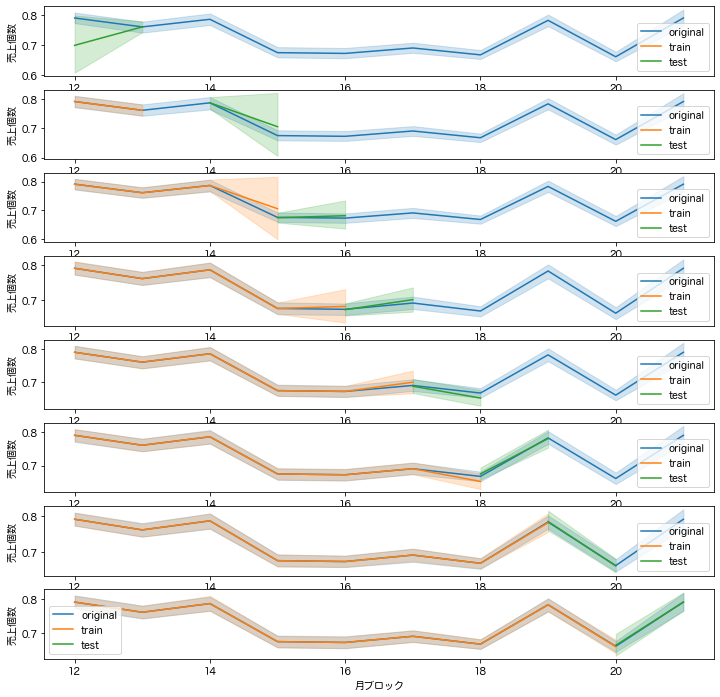

In [60]:
# df = pd.merge(X_trainval, y_trainval, right_index=True, left_index=True)

# n_splits = 8

# # データの並び順をシャッフルする
# df = df.sample(frac=1.0, random_state=42)

# # 特定のカラムを時系列としてソートした分割
# folds = MovingWindowKFold(ts_column='月ブロック', n_splits=n_splits)

# fig, axes = plt.subplots(n_splits, 1, figsize=(12, 12))

# # 元々のデータを時系列ソートした iloc が添字として得られる
# for i, (train_index, test_index) in enumerate(folds.split(df)):
#     #print(f'index of train: {train_index}')
#     #print(f'index of test: {test_index}')
#     #print('----------')
#     sns.lineplot(data=df, x='月ブロック', y='売上個数', ax=axes[i], label='original')
#     sns.lineplot(data=df.iloc[train_index], x='月ブロック', y='売上個数', ax=axes[i], label='train')
#     sns.lineplot(data=df.iloc[test_index], x='月ブロック', y='売上個数', ax=axes[i], label='test')

# plt.legend()
# plt.show()

In [246]:
from contextlib import contextmanager
from time import time

@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

In [247]:
import lightgbm as lgbm

from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

def fit_lgbm(X, 
             y, 
             n_splits,
             params: dict=None, 
             verbose: int=50):
    
    df = pd.merge(X, y, right_index=True, left_index=True)
    # データの並び順をシャッフルする
    df = df.sample(frac=1.0, random_state=42)
    # 特定のカラムを時系列としてソートした分割
    folds = MovingWindowKFold(ts_column='月ブロック', n_splits=n_splits)
    
    
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""
    metric_func = mean_squared_error

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    # training data の target と同じだけのゼロ配列を用意
    # float にしないと悲しい事件が起こるのでそこだけ注意
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(folds.split(df)): 
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]
        
        lgb_train = lgb.Dataset(x_train, y_train) #(DataFrame, Series)
        lgb_valid = lgb.Dataset(x_valid, y_valid, reference=lgb_train) #(DataFrame, Series)
        
        # 学習
        evaluation_results  = {}  # to record evaluation results for plotting
        with timer(prefix='fit fold={} '.format(i + 1)):
            model = lgb.train(params, 
                      lgb_train,
                      valid_names=['train', 'valid'], 
                      valid_sets=[lgb_train, lgb_valid],
                     evals_result = evaluation_results,
                    verbose_eval=verbose)
            
        pred_i = model.predict(x_valid, num_iteration=model.best_iteration)

        oof_pred[idx_valid] = pred_i
        models.append(model)

        print(f'Fold {i} RMSLE: {metric_func(y_valid, pred_i) ** .5:.4f}')

    score = metric_func(y, oof_pred) ** .5
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

In [248]:
params = {
    # 目的関数. これの意味で最小となるようなパラメータを探します. 
    'objective': 'rmse', 

     # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、
    # がそれだけ木を作るため学習に時間がかかります
    'learning_rate': 0.01,

    # L2 Reguralization
    'reg_lambda': 1.,
    # こちらは L1 
    'reg_alpha': .1,

    # 木の深さ. 深い木を許容するほどより複雑な交互作用を考慮するようになります
    'max_depth': 5, 

    # 木の最大数. early_stopping という枠組みで木の数は制御されるようにしていますのでとても大きい値を指定しておきます.
    'n_estimators': 10000, 

    # 木を作る際に考慮する特徴量の割合. 1以下を指定すると特徴をランダムに欠落させます。小さくすることで, まんべんなく特徴を使うという効果があります.
    'colsample_bytree': .5, 

    # 最小分割でのデータ数. 小さいとより細かい粒度の分割方法を許容します.
    'min_child_samples': 10,

    # bagging の頻度と割合
    'subsample_freq': 3,
    'subsample': .9,

    # 特徴重要度計算のロジック(後述)
    'importance_type': 'gain', 
    'random_state': 71,
}

params_update_flag = True

if params_update_flag:    
    params.update(best_params)
    params['num_leaves'] = int(best_params['num_leaves'])
    params['min_child_samples'] = int(best_params['min_child_samples'])
    params['bagging_freq'] = int(best_params['bagging_freq'])
print(params)

{'objective': 'regression', 'learning_rate': 0.01, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'max_depth': 5, 'n_estimators': 10000, 'colsample_bytree': 0.5, 'min_child_samples': 20, 'subsample_freq': 3, 'subsample': 0.9, 'importance_type': 'gain', 'random_state': 71, 'metric': 'rmse', 'random_seed': 100, 'feature_pre_filter': False, 'lambda_l1': 0.00012525855784737718, 'lambda_l2': 1.3977299663659115e-05, 'num_leaves': 218, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 0.45229279968230685, 'bagging_freq': 3, 'num_iterations': 5000, 'early_stopping_round': 3}


In [249]:
y = y_trainval.copy()
y = np.log1p(y) # log + plus1 変換する

In [250]:
n_splits = 5
oof, models = fit_lgbm(X_trainval, y, n_splits, params=params)

[LightGBM] [Warning] seed is set with random_seed=100, random_state=71 will be ignored. Current value: seed=100
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=3 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l1 is set=0.00012525855784737718, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0.00012525855784737718
[LightGBM] [Warning] feature_fraction is set=0.8999999999999999, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.8999999999999999
[LightGBM] [Warning] lambda_l2 is set=1.3977299663659115e-05, reg_lambda=1.0 will be ignored. Current value: lambda_l2=1.3977299663659115e-05
[LightGBM] [Warning] bagging_fraction is set=0.45229279968230685, subsample=0.9 will be ignored. Current value: bagging_fraction=0.45229279968230685
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] seed is set with random_seed=100, ran

## 学習の確認

In [93]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importance(importance_type='gain')
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
    sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig, ax

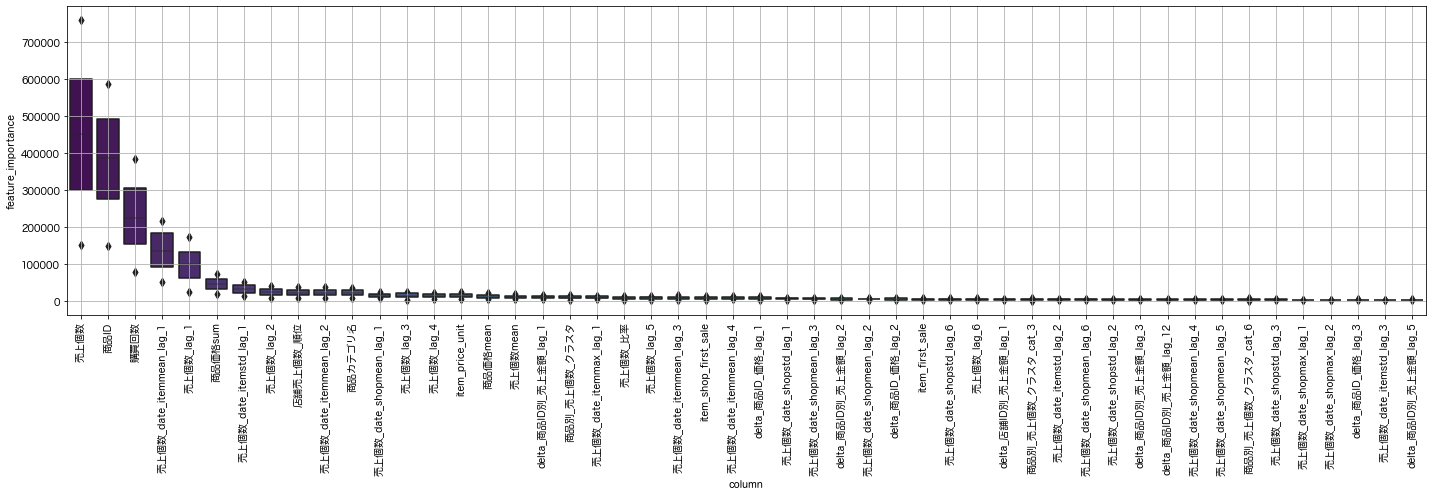

In [94]:
fig, ax = visualize_importance(models, X_trainval)

## 誤差の確認

In [98]:
comparison_df = pd.DataFrame(y_trainval).rename(columns={'売上個数_2month': 'true'})
comparison_df['pred'] = np.expm1(oof)

comparison_df['予測との誤差'] = np.sqrt((comparison_df['true'] - comparison_df['pred'])**2)
comparison_df['index'] = comparison_df.sort_values('予測との誤差', ascending=False).reset_index().index
comparison_df

,true,pred,予測との誤差,index
988722,0.0,1.069482,1.069482,0
988723,1.0,0.560327,0.439673,1
988724,0.0,0.143817,0.143817,2
988725,2.0,0.274029,1.725971,3
988726,3.0,0.811409,2.188591,4
...,...,...,...,...
1533613,0.0,-0.004230,0.004230,544891
1533614,0.0,0.035858,0.035858,544892
1533615,0.0,0.033534,0.033534,544893
1533616,0.0,0.010722,0.010722,544894


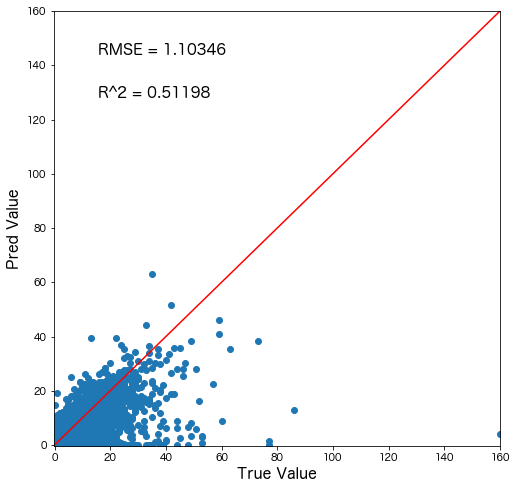

In [99]:
True_Pred_map(comparison_df[['true', 'pred']])

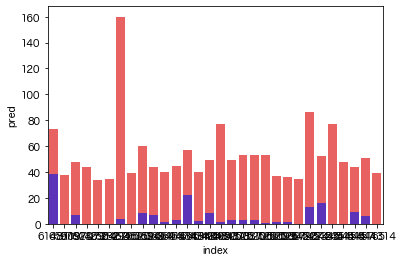

In [100]:
plt.subplot()
sns.barplot(x='index', y='true', data=comparison_df.sort_values('予測との誤差', ascending=False)[:30],color='red', alpha=0.7)
sns.barplot(x='index', y='pred', data=comparison_df.sort_values('予測との誤差', ascending=False)[:30],color='blue', alpha=0.7)
plt.show()

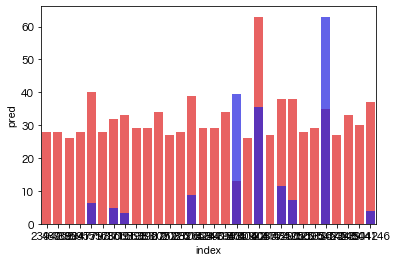

In [101]:
plt.subplot()
sns.barplot(x='index', y='true', data=comparison_df.sort_values('予測との誤差', ascending=False)[30:60],color='red', alpha=0.7)
sns.barplot(x='index', y='pred', data=comparison_df.sort_values('予測との誤差', ascending=False)[30:60],color='blue', alpha=0.7)
plt.show()

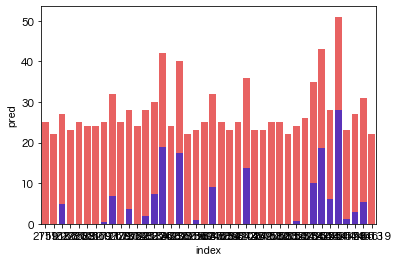

In [102]:
plt.subplot()
sns.barplot(x='index', y='true', data=comparison_df.sort_values('予測との誤差', ascending=False)[60:100],color='red', alpha=0.7)
sns.barplot(x='index', y='pred', data=comparison_df.sort_values('予測との誤差', ascending=False)[60:100],color='blue', alpha=0.7)
plt.show()

# 誤差の多いやつを再学習

In [45]:
# Failure_index = comparison_df[comparison_df['予測との誤差'] > 10].index
# len(Failure_index)

In [265]:
Failure_index = comparison_df.sort_values('予測との誤差', ascending=False).head(100000).sort_index().index
len(Failure_index)

100000

In [266]:
Failure_X_trainval = X_trainval.loc[Failure_index]
Failure_y = y[Failure_index]

In [268]:
params = {
     "objective":"regression",
    'objective': 'rmse', # 目的関数. これの意味で最小となるようなパラメータを探します. 
    'learning_rate': 0.1, # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、がそれだけ木を作るため学習に時間がかかります
    'max_depth': 6, # 木の深さ. 深い木を許容するほどより複雑な交互作用を考慮するようになります
    'n_estimators': 10000, # 木の最大数. early_stopping という枠組みで木の数は制御されるようにしていますのでとても大きい値を指定しておきます.
    'colsample_bytree': .5, # 木を作る際に考慮する特徴量の割合. 1以下を指定すると特徴をランダムに欠落させます。小さくすることで, まんべんなく特徴を使うという効果があります.
    'importance_type': 'gain', # 特徴重要度計算のロジック(後述)
    "random_seed":0,
}

if params_update_flag:    
    params.update(best_params)
    params['num_leaves'] = int(best_params['num_leaves'])
    params['min_child_samples'] = int(best_params['min_child_samples'])
    params['bagging_freq'] = int(best_params['bagging_freq'])
print(params)

n_splits = 3
Failure_oof, Failure_models = fit_lgbm(Failure_X_trainval, Failure_y, n_splits, params=params)

for model in Failure_models:
    models.append(model)

{'objective': 'regression', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 10000, 'colsample_bytree': 0.5, 'importance_type': 'gain', 'random_seed': 100, 'metric': 'rmse', 'feature_pre_filter': False, 'lambda_l1': 0.00012525855784737718, 'lambda_l2': 1.3977299663659115e-05, 'num_leaves': 218, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 0.45229279968230685, 'bagging_freq': 3, 'min_child_samples': 20, 'num_iterations': 5000, 'early_stopping_round': 3}
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] feature_fraction is set=0.8999999999999999, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.8999999999999999
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] feature_fraction is set=0.8999999999999999, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.8999999999999999
[LightGBM] [Warning] A

# 提出用ファイルの作成

In [269]:
models

In [270]:
def revert_to_real(y_log):
    _pred = np.expm1(y_log)
    _pred = np.where(_pred < 0, 0, _pred)
    return _pred

pred = np.array([model.predict(X_test.values) for model in models])
pred = np.mean(pred, axis=0)
pred = revert_to_real(pred)

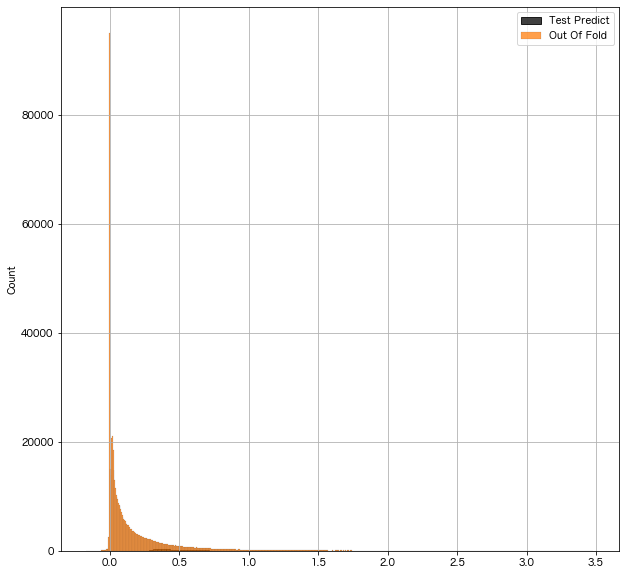

In [271]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.histplot(np.log1p(pred), label='Test Predict', ax=ax, color='black')
sns.histplot(oof, label='Out Of Fold', ax=ax, color='C1')
ax.legend()
ax.grid()

In [272]:
# sample_submissionの中身を確認
sub.head()

,0,1
0,0,0.527821
1,1,0.238340
2,2,0.666246
3,3,0.663804
4,4,0.359945


In [273]:
# sample_submissionの右側のカラムに予測値を代入する。
sub.iloc[:, -1] = pred

sub.head()

,0,1
0,0,0.823992
1,1,0.551390
2,2,0.950478
3,3,0.886345
4,4,0.665373


In [274]:
# 予測ファイルの生成
sub.to_csv('./outputs/submission21_LightGBM_TimeSeriesSplit_model_2month_addfail.csv', index=False, header=False)

# → 去年の12月と同じ * 0.77, 去年売れてないやつはモデル予測

In [117]:
test_df = pd.read_csv('./inputs/test.csv')
sales_history_addfeature_df = pd.read_pickle('./inputs/sales_history_addfeature1.pickle')

In [118]:
submit_df = test_df.copy()
submit_df = submit_df.set_index('index')
submit_df[['店舗ID', '商品ID']] = submit_df[['店舗ID', '商品ID']].astype(str)
submit_df

,商品ID,店舗ID
index,,
0,1000001,0
1,1000001,1
2,1000001,2
3,1000001,3
4,1000001,4
...,...,...
3055,3500001,13
3056,3500001,14
3057,3500001,15


### 2018年12月で絞り込み

In [119]:
df_isin_test = sales_history_addfeature_df[sales_history_addfeature_df['商品ID'].isin(test_df['商品ID'].astype(str))]
df_isin_test_201812 = df_isin_test[(df_isin_test['日付'] >= '2018-12-01') & (df_isin_test['日付'] <= '2018-12-31')]
df_isin_test_201812_sort = df_isin_test_201812.sort_values(["日付", "店舗ID", "商品ID"])
df_isin_test_201812_sort = df_isin_test_201812_sort.set_index('日付')
df_isin_test_201812_group = df_isin_test_201812_sort.groupby(['商品ID', '店舗ID']).agg({"売上個数": ["sum"]})
df_isin_test_201812_group = df_isin_test_201812_group.sort_values(['商品ID','店舗ID']).reset_index()
df_isin_test_201812_group.columns = ["".join(c) for c in df_isin_test_201812_group.columns]

In [120]:
df_isin_test_201812_group

,商品ID,店舗ID,売上個数sum
0,1000001,10,3.0
1,1000001,11,2.0
2,1000001,12,2.0
3,1000001,13,4.0
4,1000001,16,1.0
...,...,...,...
1777,3500001,13,3.0
1778,3500001,17,1.0
1779,3500001,2,1.0
1780,3500001,3,1.0


In [121]:
#去年12月
sub = pd.merge(submit_df, df_isin_test_201812_group, on=['商品ID','店舗ID'], how='left')
sub = sub[['商品ID', '店舗ID', '売上個数sum']]
sub['売上個数sum'] = sub['売上個数sum'] * 0.7730087581405793
#モデル結果
sub['y_pred'] = y_pred
sub

,商品ID,店舗ID,売上個数sum,y_pred
0,1000001,0,NaN,0.664004
1,1000001,1,NaN,0.604367
2,1000001,2,NaN,0.794004
3,1000001,3,9.0,1.214369
4,1000001,4,7.0,2.418132
...,...,...,...,...
3055,3500001,13,3.0,1.012676
3056,3500001,14,NaN,0.768535
3057,3500001,15,NaN,0.795457
3058,3500001,16,NaN,0.786145


In [122]:
sub['売上個数sum_addpred'] = np.where(sub['売上個数sum'].isnull(), sub['y_pred'], sub['売上個数sum'])
sub['売上個数_予測'] = sub['売上個数sum_addpred'].fillna(0)
sub

,商品ID,店舗ID,売上個数sum,y_pred,売上個数sum_addpred,売上個数_予測
0,1000001,0,NaN,0.664004,0.664004,0.664004
1,1000001,1,NaN,0.604367,0.604367,0.604367
2,1000001,2,NaN,0.794004,0.794004,0.794004
3,1000001,3,9.0,1.214369,9.000000,9.000000
4,1000001,4,7.0,2.418132,7.000000,7.000000
...,...,...,...,...,...,...
3055,3500001,13,3.0,1.012676,3.000000,3.000000
3056,3500001,14,NaN,0.768535,0.768535,0.768535
3057,3500001,15,NaN,0.795457,0.795457,0.795457
3058,3500001,16,NaN,0.786145,0.786145,0.786145


In [123]:
sub['売上個数sum'].isnull().sum()

1278

In [124]:
#submit用のCSVを作成
final_sub = pd.DataFrame({"index":sub.index, "y":sub['売上個数_予測']})
print('sub["y"].isnull().sum()=', final_sub['y'].isnull().sum())
final_sub

sub["y"].isnull().sum()= 0


,index,y
0,0,0.664004
1,1,0.604367
2,2,0.794004
3,3,9.000000
4,4,7.000000
...,...,...
3055,3055,3.000000
3056,3056,0.768535
3057,3057,0.795457
3058,3058,0.786145


In [125]:
final_sub.to_csv('./outputs/submission20_withoutAI_addLightGBM_TimeSeriesSplit_model_adddummy11_fail.csv', header=False, index=False)